https://www.youtube.com/watch?v=zp8clK9yCro
original -> encoder -> decoder -> reconstructed

FFNN or CNN, generative
minimize MSE loss

each operation in encoder should be reversed in decoder
nn.Conv2D in encoder -> nn.ConvTranspose2D in decoder


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# toTensor converts the input data from whatever format to a tensor
transform = transforms.ToTensor()
# importing dataset
mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform=transform)
# creating dataloader object
data_loader = torch.utils.data.DataLoader(dataset = mnist_data, batch_size=64, shuffle=True)

tensor(0.) tensor(1.)


In [4]:

# create an iterator object
dataiter = iter(data_loader)
# get image and label of first thing
images, labels = next(dataiter)
print(torch.min(images), torch.max(images)) # currently values are between 0 and 1

tensor(0.) tensor(1.)


In [ ]:
# create autoencoder class: inheriting from nn.Module
class Autoencoder_linear(nn.Module):
    def __init__(self):
        # initialize super class
        super().__init__()

        # size is (N, 784) where N is batch size and 784 is the image size (28x28)
        # reduce with some linear layers
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # reduce from (N,784) -> (N,128)
            nn.ReLU(),

            nn.Linear(128, 64), 
            nn.ReLU(),

            nn.Linear(64, 12), 
            nn.ReLU(),

            nn.Linear(12, 3) # final output size is (N, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12), # increase from (N,3) -> (N,12)
            nn.ReLU(),

            nn.Linear(12, 64), 
            nn.ReLU(),

            nn.Linear(64, 128), 
            nn.ReLU(),

            nn.Linear(128, 28*28), # final output size is (N, 784)

            nn.Sigmoid() # to get values from 0-1
        )
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded
    
    # note: if final output range was [-1, 1], then the tanh activation function 
    # would be needed instead of sigmoid


why is padding required?
- with a 5x5 input image and a 3x3 filter, using a stride of 1, the feature map output will be 3x3. As more convo layers are added, the spatial dimensions will keep decreasing. 
- the pixels at the borders of the input image are in fewer convolutions than the ones in the center; if important features are at the edges, this can impact performance of the model
- padding is adding extra rows/columns around the borders of an image  

for a NxN input image and FxF kernel filter, the shape of the output map without padding is:  
$$(n - f + 1) X (n - f + 1) $$
to maintain the same spatial dimensions after convolution, we want to set (n - f + 1) = n, which means padding input to (n - f + 1) by (n - f + 1). This is usually done by adding extra rows/columns of ZEROS on the edges (zero padding)  
To calculate output shape after padding:  
$$ output shape = (n + 2p - f + 1) X (n + 2p - f + 1)$$  


What is a stride?
- the stride defines how much the filter shifts across the image. Usual default stride is (1,1) which means the filter shifts by one pixel each time.
- increasing stride means increasing the number of pixels that are skipped: stride 1 means no pixels skipped, stride 2 means 1 pixel skipped in each row/column between strides, stride 3 means 2 pixels skipped, etc
$$ output shape = (\frac{n + 2p - f}{s + 1}) x (\frac{n + 2p - f}{s + 1})$$  

https://medium.com/@Tms43/understanding-padding-strides-in-convolutional-neural-networks-cnn-for-effective-image-feature-1b0756a52918#:~:text=In%20summary%2C%20padding%20allows%20you,getting%20good%20performance%20from%20CNNs.

In [26]:
# create autoencoder class: inheriting from nn.Module
class Autoencoder_cnn(nn.Module):
    def __init__(self):
        # initialize super class
        super().__init__()

        # size is (N, 1, 28, 28) for CNN
        self.encoder = nn.Sequential(
            # (input, output, kernel size, stride, padding)
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),

            nn.Conv2d(32, 64, 7) # N, 64, 1, 1

        )

        self.decoder = nn.Sequential(
            # N, 64, 1, 1
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),

            # output_padding adds zeros to make it n,16,14,14, instead of n,16,13,13)
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N,1,28,28

            nn.Sigmoid() # to get values from 0-1
        )
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded
    
    # note: if final output range was [-1, 1], then the tanh activation function 
    # would be needed instead of sigmoid

    # note: nn.MaxPool2d reduces size, to revert use nn.MaxUnpool2d
    # or could use stride and padding sizes for same effect


In [27]:
ae_model = Autoencoder_cnn()
criterion = nn.MSELoss() # mean squared error loss
# optimizer(what to optimize, learning rate, weight decay)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3, weight_decay=1e-5)

In [28]:
# training loop
num_epochs = 1
outputs = []

# iterate over the number of epochs
for epoch in range(num_epochs):
    # dataloader provides batches of images and labels; _ ignores labels since 
    # training unsupervised
    for (img, _) in data_loader:
        # reshaping: unneeded for CNN
        # -1 means python infers batch size from the number of elements
        #img = img.reshape(-1, 28*28) # flattening from (N, 1, 28, 28) to (N, 784). -1 
        
        recon = ae_model(img) # img is passed through ae model (output is reconstructed image)
        loss = criterion(recon, img) # determining loss between original and reconstructed

        optimizer.zero_grad() # clears previous gradients
        loss.backward() # back prop to get new gradients
        optimizer.step() # updating model weights based on gradients
    
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0089


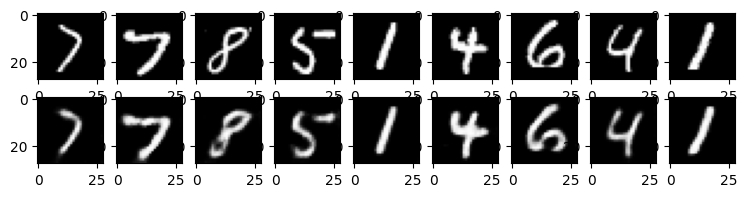

In [29]:
# plotting reconstructed images vs original
for k in range(0, num_epochs, 1):
    plt.figure(figsize=(9,2))
    plt.gray()
    # converting from tensor to numpy array to plot
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #reversing reshape back to 28, 28 image
        #item = item.reshape(-1, 28, 28)
        # items: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # rowlength +i +1
        #reversing reshape back to 28, 28 image
        #item = item.reshape(-1, 28, 28)
        # items: 1, 28, 28
        plt.imshow(item[0])